In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from loadmodules import *

In [2]:
%matplotlib inline

In [17]:
path = './'
simulation_list = [directory for directory in os.listdir(path) if 'iso_gal_aur' in directory]

In [18]:
simulation_list

['iso_gal_aur']

In [19]:
def get_massloss_rates(simulation, low_limit=None, high_limit=None, age_lowlimit=0., scatter_plots=False, isolated_sim=False):
    if isolated_sim:
        s = gadget_readsnap(30, snappath=simulation+'/output/', hdf5=True, loadonlytype=[4])
    else:
        sf = load_subfind(127, dir=simulation+'/output/', hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
        s = gadget_readsnap(127, snappath=simulation+'/output/', hdf5=True, subfind=sf, loadonlyhalo=0, loadonlytype=[4] )
        s.calc_sf_indizes( sf )
        galrad = 0.1 * sf.data['frc2'][0]
        s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

    s.data['pos'] *= 1e3 # in kpc
    s.data['mass'] *= 1e10 # change mass to solar masses
    s.data['mclt'] *= 1e10
    s.data['imcl'] *= 1e10
    s.data['mlsk'] *= 1e10
    s.data['mlrx'] *= 1e10

    mask_clusters_initial = (s.data['incl'] > 0 )
    
    init_cluster_masses = s.data['imcl'][mask_clusters_initial].flatten()
    cluster_masses = s.data['mclt'][mask_clusters_initial].flatten()
    mlost_shocks = s.data['mlsk'][mask_clusters_initial].flatten()
    mlost_rlx = s.data['mlrx'][mask_clusters_initial].flatten()
    disruption_time = s.data['drpt'][mask_clusters_initial].flatten()
    
    not_empty_clusters = (init_cluster_masses>0)

    init_cluster_masses = init_cluster_masses[not_empty_clusters]
    cluster_masses = cluster_masses[not_empty_clusters]
    disruption_time = disruption_time[not_empty_clusters]
    mlost_shocks = mlost_shocks[not_empty_clusters]
    mlost_rlx = mlost_rlx[not_empty_clusters]

    mlost_total = (init_cluster_masses-cluster_masses)
    
    clusters_formtime = np.repeat(s.data['age'][mask_clusters_initial], s.data['incl'][mask_clusters_initial])
    if isolated_sim:
        clusters_age = 3. - clusters_formtime*(s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s/(356.25*24*3600)/1e9)
    else:
        clusters_age = s.cosmology_get_lookback_time_from_a(clusters_formtime, is_flat=True)
    
    if (low_limit is None) and (high_limit is None):
        mass_constrain = np.ones_like(init_cluster_masses, dtype=bool) * (clusters_age>age_lowlimit)
    elif (low_limit is None) and (high_limit is not None):
        mass_constrain = (init_cluster_masses < high_limit) * (clusters_age>age_lowlimit)
    elif (high_limit is None) and (low_limit is not None):
        mass_constrain = (init_cluster_masses>low_limit) * (clusters_age>age_lowlimit)
    else:
        mass_constrain = (init_cluster_masses>low_limit) * (init_cluster_masses < high_limit) * (clusters_age>age_lowlimit)

    lifetime = np.zeros_like(init_cluster_masses)
    mask_disrupted = (disruption_time>0.)
    if isolated_sim:
        lifetime[mask_disrupted] = clusters_age[mask_disrupted] - (3. - disruption_time[mask_disrupted]*(s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s/(356.25*24*3600)/1e9))
        lifetime[~mask_disrupted] = 3.5
    else:
        lifetime[mask_disrupted] = clusters_age[mask_disrupted] - s.cosmology_get_lookback_time_from_a(disruption_time[mask_disrupted], is_flat=True)
        lifetime[~mask_disrupted] = 16.
    
    mlossrate_shocks = np.zeros_like(init_cluster_masses)
    mlossrate_rlx = np.zeros_like(init_cluster_masses)
    mlossrate_total = np.zeros_like(init_cluster_masses)

    mlossrate_shocks[~mask_disrupted] = mlost_shocks[~mask_disrupted]/(1e3*clusters_age[~mask_disrupted])
    mlossrate_rlx[~mask_disrupted] = mlost_rlx[~mask_disrupted]/(1e3*clusters_age[~mask_disrupted])
    mlossrate_total[~mask_disrupted] = mlost_total[~mask_disrupted]/(1e3*clusters_age[~mask_disrupted])

    mlossrate_shocks[mask_disrupted] = mlost_shocks[mask_disrupted]/(1e3*lifetime[mask_disrupted])
    mlossrate_rlx[mask_disrupted] = mlost_rlx[mask_disrupted]/(1e3*lifetime[mask_disrupted])
    mlossrate_total[mask_disrupted] = mlost_total[mask_disrupted]/(1e3*lifetime[mask_disrupted])

    if scatter_plots:
        fig, ax = plt.subplots(1, 3, figsize=(20,5))
        ax[0].hist2d(np.log10(init_cluster_masses[mass_constrain]), (mlost_shocks/init_cluster_masses)[mass_constrain], bins=(100,100), range=([3.5,8], [0,1]), rasterized=True, cmap=cm.viridis, norm=colors.LogNorm())
        ax[1].hist2d(np.log10(init_cluster_masses[mass_constrain]), (mlost_rlx/init_cluster_masses)[mass_constrain], bins=(100,100), range=([3.5,8], [0,1]), rasterized=True, cmap=cm.viridis, norm=colors.LogNorm())
        ax[2].hist2d(np.log10(init_cluster_masses[mass_constrain]), np.log10(lifetime[mass_constrain]), bins=(100,100), range=([3.5,8], [-2,np.log10(3.51)]), rasterized=True, cmap=cm.viridis, norm=colors.LogNorm())

    # return [(mlost_total/init_cluster_masses)[mass_constrain], mlossrate_shocks[mass_constrain], mlossrate_rlx[mass_constrain]]
    return [(mlost_total/init_cluster_masses)[mass_constrain], (mlossrate_shocks/init_cluster_masses)[mass_constrain], (mlossrate_rlx/init_cluster_masses)[mass_constrain]]
    # return [mlossrate_total[mass_constrain], mlossrate_shocks[mass_constrain], mlossrate_rlx[mass_constrain]]
    # return [(mlossrate_total/init_cluster_masses)[mass_constrain], (mlossrate_shocks/init_cluster_masses)[mass_constrain], (mlossrate_rlx/init_cluster_masses)[mass_constrain]]

In [20]:
mlossrates_all = get_massloss_rates(simulation_list[0], isolated_sim=True)
mlossrates_low = get_massloss_rates(simulation_list[0], high_limit=1e5, isolated_sim=True)
mlossrates_intermediate = get_massloss_rates(simulation_list[0], low_limit=1e5, high_limit=1e6, isolated_sim=True)
mlossrates_high = get_massloss_rates(simulation_list[0], low_limit=1e6, isolated_sim=True)
# mlossrates_all = get_massloss_rates(simulation_list[2], age_lowlimit=6.)
# mlossrates_all = get_massloss_rates(simulation_list[2], age_lowlimit=10.)
# mlossrates_low = get_massloss_rates(simulation_list[2], high_limit=1e5, age_lowlimit=10.)
# mlossrates_intermediate = get_massloss_rates(simulation_list[2], low_limit=1e5, high_limit=1e6, age_lowlimit=10.)
# mlossrates_high = get_massloss_rates(simulation_list[2], low_limit=1e6, age_lowlimit=10.)

/home/pdcg/pylib/gadget_snap.py:730: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


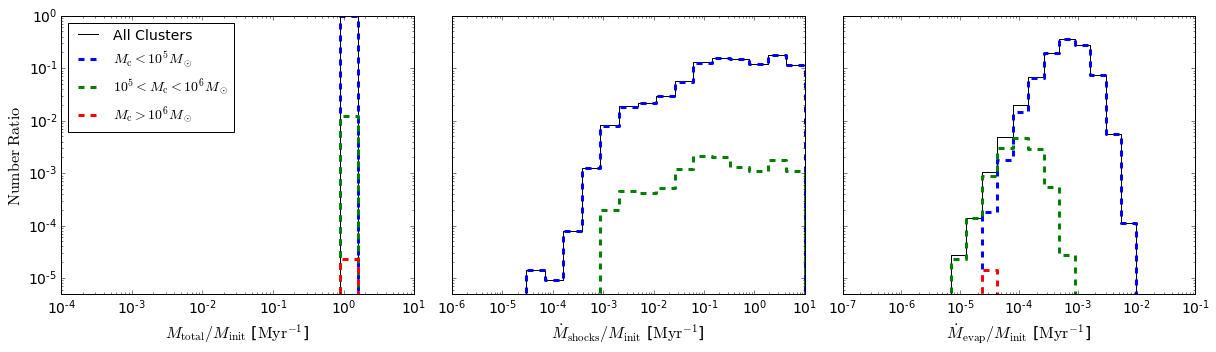

In [ ]:
bins0 = np.logspace(-4,1,20)
bins1 = np.logspace(-6,1,20)
bins2 = np.logspace(-7,-2,20)
# bins2 = np.linspace(0,80,20)
fig, ax = plt.subplots(1,3, figsize=(17,5), sharey=True)
N, _ = np.histogram(mlossrates_all[0], bins=bins0)
ax[0].step(bins0, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='k', linewidth=1, label='All Clusters')
N, _ = np.histogram(mlossrates_low[0], bins=bins0)
ax[0].step(bins0, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='b', linewidth=3, linestyle='dashed', label=r'$M_{\rm{c}}<10^5 M_\odot$')
N, _ = np.histogram(mlossrates_intermediate[0], bins=bins0)
ax[0].step(bins0, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='g', linewidth=3, linestyle='dashed', label=r'$10^5<M_{\rm{c}}<10^6 M_\odot$')
N, _ = np.histogram(mlossrates_high[0], bins=bins0)
ax[0].step(bins0, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='r', linewidth=3, linestyle='dashed', label=r'$M_{\rm{c}}>10^6 M_\odot$')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim(5e-6,1e0)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_xlabel(r'$M_{\rm{total}}/M_{\rm{init}}$ [$\rm{Myr}^{-1}$]', fontsize=16)
ax[0].set_ylabel(r'$\rm{Number \; Ratio}$', fontsize=16)

N, _ = np.histogram(mlossrates_all[1], bins=bins1)
ax[1].step(bins1, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='k',linewidth=1, label='All Clusters')
N, _ = np.histogram(mlossrates_low[1], bins=bins1)
ax[1].step(bins1, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='b',linewidth=3, linestyle='dashed', label=r'$M_{\rm{c}}<10^5 M_\odot$')
N, _ = np.histogram(mlossrates_intermediate[1], bins=bins1)
ax[1].step(bins1, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='g',linewidth=3, linestyle='dashed', label=r'$10^5<M_{\rm{c}}<10^6 M_\odot$')
N, _ = np.histogram(mlossrates_high[1], bins=bins1)
ax[1].step(bins1, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='r',linewidth=3, linestyle='dashed', label=r'$M_{\rm{c}}>10^6 M_\odot$')
ax[1].set_xscale('log')
ax[1].tick_params(axis='both', which='major', labelsize=14)
# xticks = ax[1].get_xticks()
# ax[1].set_xticks(xticks[::2])
ax[1].set_xlabel(r'$\dot{M}_{\rm{shocks}}/M_{\rm{init}}$ [$\rm{Myr}^{-1}$]', fontsize=16)

N, _ = np.histogram(mlossrates_all[2], bins=bins2)
ax[2].step(bins2, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='k',linewidth=1, label='All Clusters')
N, _ = np.histogram(mlossrates_low[2], bins=bins2)
ax[2].step(bins2, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='b',linewidth=3, linestyle='dashed', label=r'$M_{\rm{c}}<10^5 M_\odot$')
N, _ = np.histogram(mlossrates_intermediate[2], bins=bins2)
ax[2].step(bins2, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='g',linewidth=3, linestyle='dashed', label=r'$10^5<M_{\rm{c}}<10^6 M_\odot$')
N, _ = np.histogram(mlossrates_high[2], bins=bins2)
ax[2].step(bins2, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='r',linewidth=3, linestyle='dashed', label=r'$M_{\rm{c}}>10^6 M_\odot$')
ax[0].legend(loc='upper left', fontsize=14)
# ax[2].legend(loc='upper right', fontsize=14)
ax[2].set_xscale('log')
ax[2].tick_params(axis='both', which='major', labelsize=14)
ax[2].set_xlabel(r'$\dot{M}_{\rm{evap}}/M_{\rm{init}}$ [$\rm{Myr}^{-1}$]', fontsize=16)

plt.tight_layout()
# plt.savefig('plots/'+simulation_list[0]+'_specificmasslosshists.pdf')

In [ ]:
mlossrates_all = get_massloss_rates(simulation_list[3])
mlossrates_low = get_massloss_rates(simulation_list[3], high_limit=1e5)

mlossrates_intermediate = get_massloss_rates(simulation_list[3], low_limit=1e5, high_limit=1e6)
mlossrates_high = get_massloss_rates(simulation_list[3], low_limit=1e6)

/storage/home/can35/can35007/pylib/gadget_snap.py:730: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02139813154935837
Found 1434190 stars.
Rotated pos.
Rotated vel.
galrad= 0.02139813154935837
Found 1434190 stars.
Rotated pos.
Rotated vel.
galrad= 0.02139813154935837
Found 1434190 stars.
Rotated pos.
Rotated vel.
galrad= 0.02139813154935837
Found 1434190 stars.
Rotated pos.
Rotated vel.


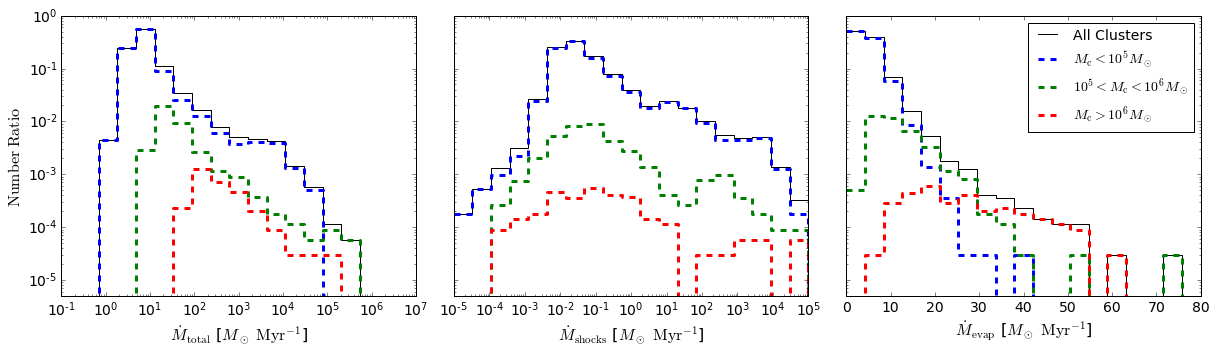

In [5]:
logbins0 = np.logspace(-1,7,20)
logbins1 = np.logspace(-5,5,20)
linearbins = np.linspace(0,80,20)
fig, ax = plt.subplots(1,3, figsize=(17,5), sharey=True)
N, _ = np.histogram(mlossrates_all[0], bins=logbins0)
ax[0].step(logbins0, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='k', linewidth=1, label='All Clusters')
N, _ = np.histogram(mlossrates_low[0], bins=logbins0)
ax[0].step(logbins0, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='b', linewidth=3, linestyle='dashed', label=r'$M_{\rm{c}}<10^5 M_\odot$')
N, _ = np.histogram(mlossrates_intermediate[0], bins=logbins0)
ax[0].step(logbins0, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='g', linewidth=3, linestyle='dashed', label=r'$10^5<M_{\rm{c}}<10^6 M_\odot$')
N, _ = np.histogram(mlossrates_high[0], bins=logbins0)
ax[0].step(logbins0, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='r', linewidth=3, linestyle='dashed', label=r'$M_{\rm{c}}>10^6 M_\odot$')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim(5e-6,1e0)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_xlabel(r'$\dot{M}_{\rm{total}}$ [$M_\odot$ $\rm{Myr}^{-1}$]', fontsize=16)
ax[0].set_ylabel(r'$\rm{Number \; Ratio}$', fontsize=16)

N, _ = np.histogram(mlossrates_all[1], bins=logbins1)
ax[1].step(logbins1, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='k',linewidth=1, label='All Clusters')
N, _ = np.histogram(mlossrates_low[1], bins=logbins1)
ax[1].step(logbins1, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='b',linewidth=3, linestyle='dashed', label=r'$M_{\rm{c}}<10^5 M_\odot$')
N, _ = np.histogram(mlossrates_intermediate[1], bins=logbins1)
ax[1].step(logbins1, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='g',linewidth=3, linestyle='dashed', label=r'$10^5<M_{\rm{c}}<10^6 M_\odot$')
N, _ = np.histogram(mlossrates_high[1], bins=logbins1)
ax[1].step(logbins1, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='r',linewidth=3, linestyle='dashed', label=r'$M_{\rm{c}}>10^6 M_\odot$')
ax[1].set_xscale('log')
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_xlabel(r'$\dot{M}_{\rm{shocks}}$ [$M_\odot$ $\rm{Myr}^{-1}$]', fontsize=16)

N, _ = np.histogram(mlossrates_all[2], bins=linearbins)
ax[2].step(linearbins, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='k',linewidth=1, label='All Clusters')
N, _ = np.histogram(mlossrates_low[2], bins=linearbins)
ax[2].step(linearbins, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='b',linewidth=3, linestyle='dashed', label=r'$M_{\rm{c}}<10^5 M_\odot$')
N, _ = np.histogram(mlossrates_intermediate[2], bins=linearbins)
ax[2].step(linearbins, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='g',linewidth=3, linestyle='dashed', label=r'$10^5<M_{\rm{c}}<10^6 M_\odot$')
N, _ = np.histogram(mlossrates_high[2], bins=linearbins)
ax[2].step(linearbins, np.append(N,0.)/len(mlossrates_all[0]), where='post', color='r',linewidth=3, linestyle='dashed', label=r'$M_{\rm{c}}>10^6 M_\odot$')
ax[2].legend(loc='upper right', fontsize=14)
ax[2].tick_params(axis='both', which='major', labelsize=14)
ax[2].set_xlabel(r'$\dot{M}_{\rm{evap}}$ [$M_\odot$ $\rm{Myr}^{-1}$]', fontsize=16)

plt.tight_layout()
# plt.savefig('plots/'+simulation_list[3]+'_masslossrates.pdf')